# Last day prediction

In this notebook we will test the last day prediction to see how well the estimate is if we use the closing value x days ago as a prediction of stock prices.
We will use this as a benchmark for more complex models.

In [1]:
import matplotlib

from sklearn.model_selection import train_test_split
from IPython.display import display

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from utils.column_modifiers import target_generator
from utils.column_modifiers import keep_columns
from utils.visualizations import plot_true_and_prediction
from utils.scorers import normalized_root_mean_square_error
from estimators.predictions import calculate_rolling_prediction
from estimators import latest_day

In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot as plt

Load the S&P 500 (as `^GSPC`) data

In [4]:
ochlva_data = OCHLVAData()

Load three other stocks: The stock weighted the most, the medium weighted stock and the lowest weighted stock (out of the 50 downloaded). 
We do this in order to get a better feeling of the model.

In [5]:
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], 
                    symbols.iloc[len(symbols)//2], 
                    symbols.iloc[-1])

for s in selected_symbols:
    ochlva_data.load_data(s)

<IPython.core.display.Javascript object>


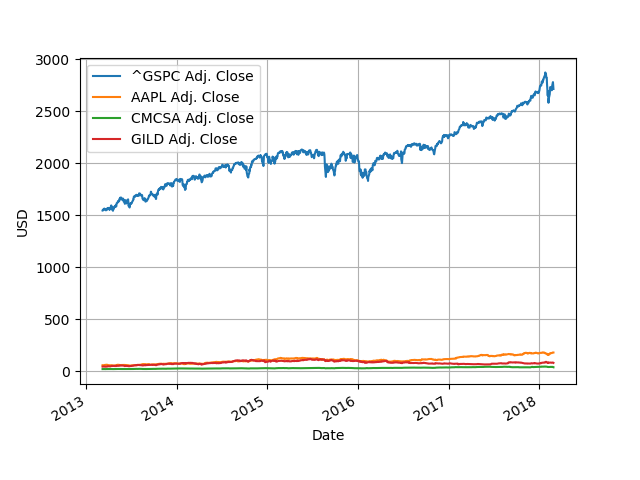

In [6]:
ax = ochlva_data.plot(['Adj. Close'])
plt.show()

For now, we will only be interested in training using the adjusted close values.

In [7]:
# Keep only 'Adj. Close' column
ochlva_data.transform(keep_columns, ['Adj. Close'], copy=False)

Next, we create the target values for the data.
The target columns will be shifted 7, 14 and 28 days with respect to 'Adj. Close'.

In [8]:
days = [7, 14, 28]
ochlva_data.transform(target_generator, 'Adj. Close', days, copy=False)

We initialize the regressor.
Note that only one instance is needed.

In [9]:
reg = latest_day.LatestDay()

We will now loop over the symbols in our `ochlva_data`.
Specifically we will:

1. Split the data into a training set and test set, and visualize the two sets 
2. Make a "rolling" prediction. That is, we will
	1. Make a prediction based on the training set.
	2. Add the earliest observation from the test set to the training set, retrain the model and make a new prediction
	3. Add the two earliest observation from the test set to the training set, retrain the model and make a new prediction, and so on util predictions have been performed for the entire test set.
3. Vizualise the result for the 7 day prediction and 14 day prediction
4. Report the averaged normalized root mean squared error (see `scorers.py` for details)

Processing ^GSPC
Head of features
Head of targets
Train shape: (1008, 1)
Test shape: (252, 1)


<IPython.core.display.Javascript object>


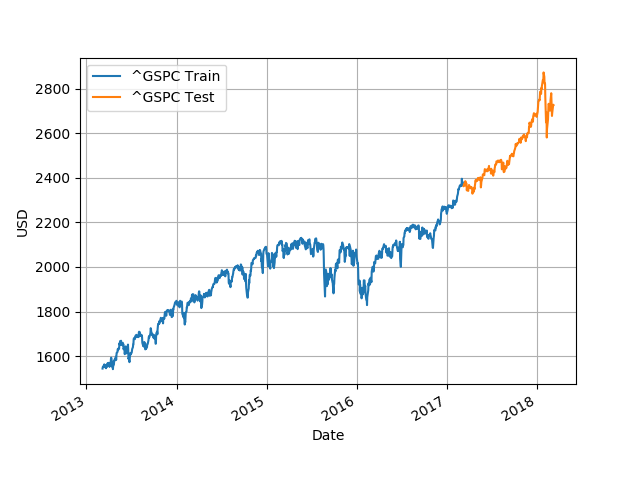

<IPython.core.display.Javascript object>


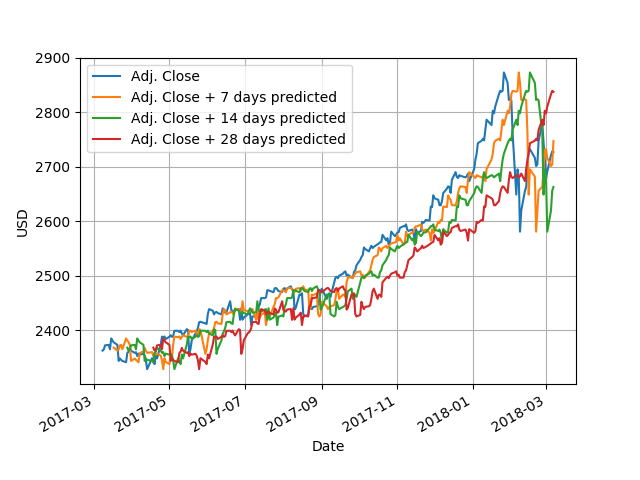

Normalized root mean squared error (averaged for the three predictions): 7.01011187317512
--------------------------------------------------------------------------------






Processing AAPL
Head of features
Head of targets
Train shape: (1002, 1)
Test shape: (251, 1)


<IPython.core.display.Javascript object>


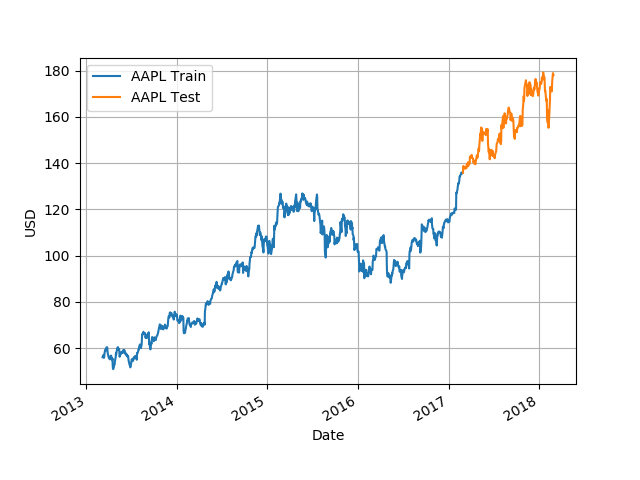

<IPython.core.display.Javascript object>


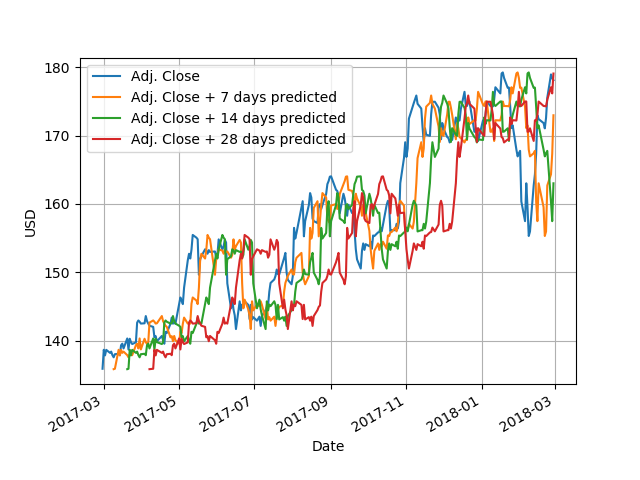

Normalized root mean squared error (averaged for the three predictions): 1.4970844050834327
--------------------------------------------------------------------------------






Processing CMCSA
Head of features
Head of targets
Train shape: (1005, 1)
Test shape: (252, 1)


<IPython.core.display.Javascript object>


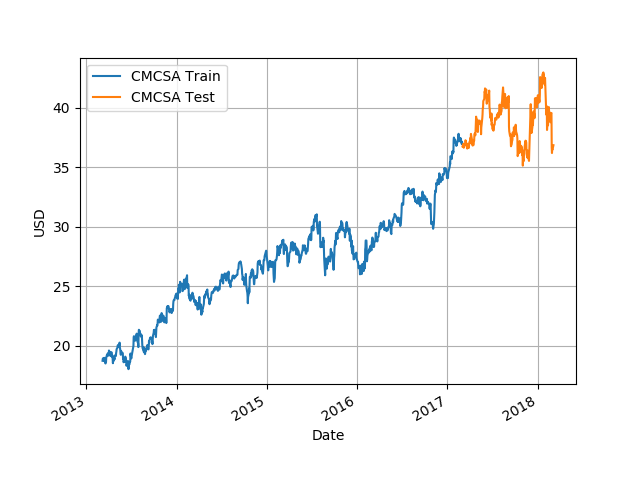

<IPython.core.display.Javascript object>


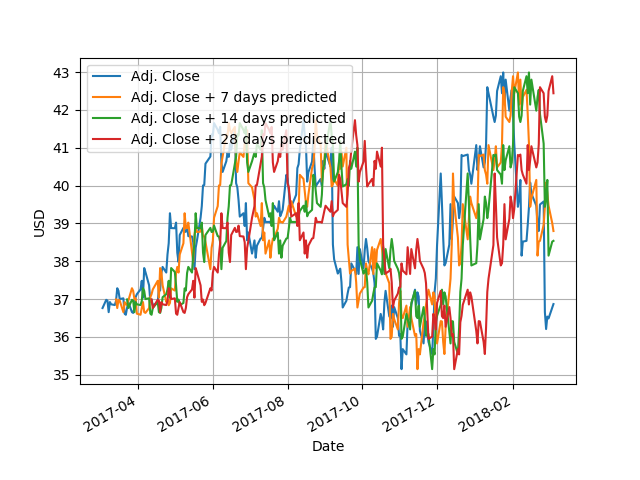

Normalized root mean squared error (averaged for the three predictions): 0.5089917884266323
--------------------------------------------------------------------------------






Processing GILD
Head of features
Head of targets
Train shape: (1006, 1)
Test shape: (252, 1)


<IPython.core.display.Javascript object>


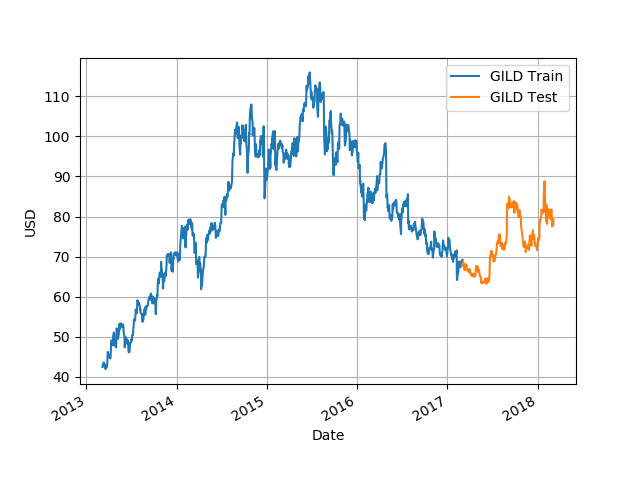

<IPython.core.display.Javascript object>


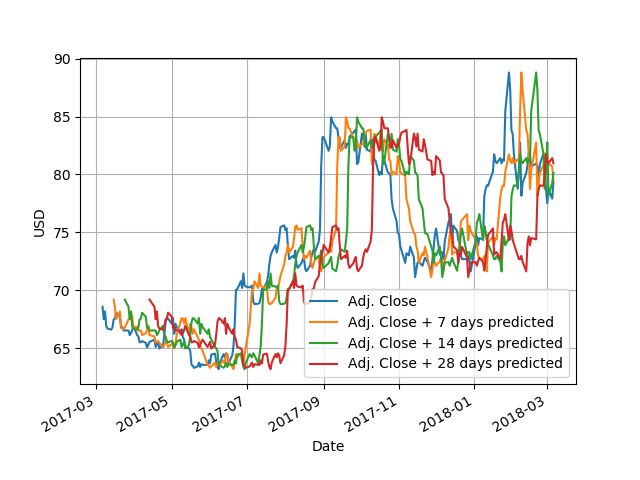

Normalized root mean squared error (averaged for the three predictions): 0.9364518171904758
--------------------------------------------------------------------------------








In [10]:
# Looping thorugh the stocks
for key in ochlva_data.transformed_data.keys():
    print(f'Processing {key}')
    # Extract the features and targets
    # NOTE: We have multiple targets
    x = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[:-len(days)]] 
    y = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[-len(days):]]

    print('Head of features')
    #display(x.head())
    print('Head of targets')
    #display(y.head())
    
    # NOTE: We could use sklearn.model_selection.TimeSeriesSplit for splitting 
    # the data
    # However, as we are not doing any form of cross-validation, it is here 
    # more convenient to utilize train_test_split
    x_train, x_test, y_train, y_test = \
        train_test_split(x, y, shuffle=False, test_size=.2)
    
    print(f'Train shape: {x_train.shape}')
    print(f'Test shape: {x_test.shape}')
    
    # Plot the train and test set
    ax = x_train.plot()
    _ = x_test.plot(ax=ax)
    ax.legend([f'{key} Train', f'{key} Test'])
    ax.grid()
    _ = ax.set_ylabel('USD')

    plt.show()
    
    # Make predictions
    #y_pred = \
    #    calculate_rolling_prediction(reg, x_train, x_test, y_train, y_test)
    y_pred = \
        calculate_rolling_prediction(reg, x_train, x_test, y_train, y_test)

    # Plot the short and the long predictions seperately in order not to 
    # clutter the plot
    _ = plot_true_and_prediction(x_test, y_pred, y_label='USD')
    plt.show()
    
    # As the first prediction is on the training set, we subtract 1 in the 
    # indexing to account for this
    # Calculate the normalized root mean squared error
    nrmse = normalized_root_mean_square_error(y_test, y_pred)
    
    print((f'Normalized root mean squared error (averaged for the three '
           f'predictions): {nrmse}'))
    
    print('-'*80)
    print('\n'*5)

In [11]:
#y_pred.head(14)

In [12]:
from utils.column_modifiers import reshift_targets
#rt = reshift_targets(y_pred)

In [13]:
#y_test.head(14)

In [14]:
#rt.head(14)

In [15]:
#y_test.tail(14)

In [16]:
#rt.tail(14)

In [17]:
#x_test.tail()